# Quick Start

## Introduction
In this tutorial, you will get a quick view of `AiiDA-WorkTree`. To run this tutorial, you need to install `aiida-worktree`. Open a terminal and run:

```console
pip install aiida-worktree
```

Start the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='2fc245067596472e99d07ed3a64b1140' name='aiida'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.


### Create node
In AiiDA, one uses the `calcfunction` to do the calculation and generate new data. AiiDA-WorkTree goes one step further by transforming a `calcfunction` to a `Node`.

In [2]:
from aiida_worktree import node
from aiida.engine import calcfunction

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

# define multiply node
@node()
@calcfunction
def multiply(x, y):
    return x*y

### Create the workflow
Three steps:

- create a empty `WorkTree`
- add nodes: `add` and `multiply`.
- link the output of the `add` node to one of the `x` input of the `multiply` node.

In [3]:
from aiida_worktree import WorkTree
from aiida.orm import Int
x = Int(2.0)
y = Int(3.0)
z = Int(4.0)

nt = WorkTree("first_workflow")
nt.nodes.new(add, name="add", x=x, y=y)
nt.nodes.new(multiply, name="multiply", y=z)
nt.links.new(nt.nodes["add"].outputs[0], nt.nodes["multiply"].inputs["x"])

nt.submit(wait=True)

[INFO] 2023-07-21 15:27:17 nodetree: Create NodeTree: first_workflow


### Check status and results


In [4]:
print("State of WorkTree:   {}".format(nt.state))
print('Result of add      : {}'.format(nt.nodes["add"].node.outputs.result.value))
print('Result of multiply : {}'.format(nt.nodes["multiply"].node.outputs.result.value))

State of WorkTree:   FINISHED
Result of add      : 5
Result of multiply : 20


Generate node graph from the AiiDA process:

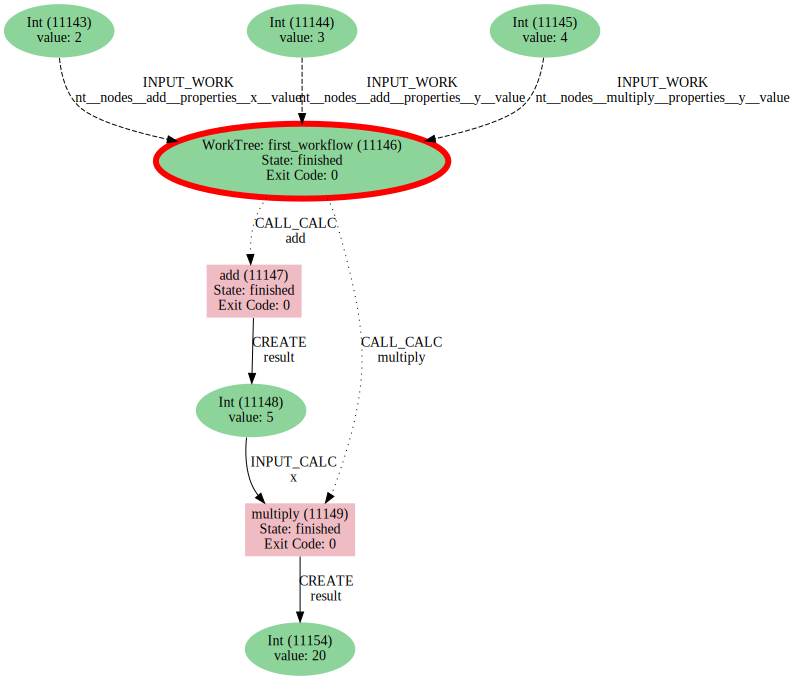

In [5]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(nt.pk)

## CalcJob and WorkChain
AiiDA uses `CalcJob` to run a calculation on a remote computer. AiiDA community also provides a lot of well-written `calcfunction` and `WorkChain`. In order to resue an existing process, one can register it as a node.

Here we build a node from CalcJob `ArithmeticAddCalculation`:

In [6]:
from aiida_worktree import build_node
ndata = {"path": "aiida.calculations.arithmetic.add.ArithmeticAddCalculation"}
add_calcjob = build_node(ndata)

The inputs and outputs of the `CalcJob` is automatically generated for the new node. One can create a node instance and inpsect its inputs and outputs:

In [7]:
node = add_calcjob()
print("Inputs:")
for input in node.inputs:
    if "." not in input.name:
        print(f"  - {input.name}")
print("Outputs:")
for output in node.outputs:
    if "." not in output.name:
        print(f"  - {output.name}")

Inputs:
  - metadata
  - code
  - monitors
  - remote_folder
  - x
  - y
Outputs:
  - remote_folder
  - remote_stash
  - retrieved
  - sum


Now, let's create a `WorkTree` to use this `Calcjob` node:

In [8]:
from aiida_worktree import WorkTree

nt = WorkTree("test_add_multiply")
nt.nodes.new("AiiDACode", "code1", value="add@localhost")
nt.nodes.new(add_calcjob, name="add1", x=x, y=y)
nt.links.new(nt.nodes["code1"].outputs[0], nt.nodes["add1"].inputs["code"])
nt.submit(wait=True)

[INFO] 2023-07-21 15:27:30 nodetree: Create NodeTree: test_add_multiply


Get the result of the nodes:

In [9]:
print('Result of node add1: {}'.format(nt.nodes["add1"].node.outputs.sum.value))

Result of node add1: 5


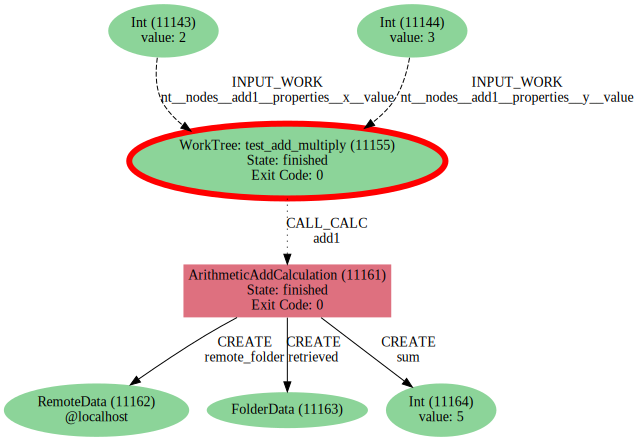

In [10]:
generate_node_graph(nt.pk)

## Node group
A `WorkTree` is a group of nodes. One can treat a `WorkTree` as a single node, and expose the inputs and outputs of the `WorkTree`. This allow you to write nested workflows.


In [11]:
from aiida_worktree import WorkTree, node

# use node.group decorator, expose the output of "multiply" node
# as the output of the `WorkTree`.
@node.group(outputs = [["multiply", "result", "result"]])
def add_multiply(x, y, z):
    # Create a WorkTree
    nt = WorkTree()
    nt.nodes.new(add, name="add", x=x, y=y)
    nt.nodes.new(multiply, name="multiply", x=z)
    nt.links.new(nt.nodes["add"].outputs[0], nt.nodes["multiply"].inputs["y"])
    return nt

Use this node group inside a `WorkTree`:

In [12]:

from aiida_worktree import WorkTree

nt = WorkTree("test_node_group")
# create a node using the node group
add_multiply1 = nt.nodes.new(add_multiply, x=x, y=y, z=z)
add_multiply2 = nt.nodes.new(add_multiply, x=x, y=y)
# link the output of int node to the input of add node
nt.links.new(add_multiply1.outputs[0], add_multiply2.inputs["z"])
nt.submit(wait=True)
print("Worktree staet: ", nt.state)

[INFO] 2023-07-21 15:27:48 nodetree: Create NodeTree: test_node_group


Worktree staet:  FINISHED


Get the result of the nodes:

In [13]:
print('Result of node add_multiply1: {}'.format(add_multiply1.node.outputs.group_outputs.result.value))

Result of node add_multiply1: 20


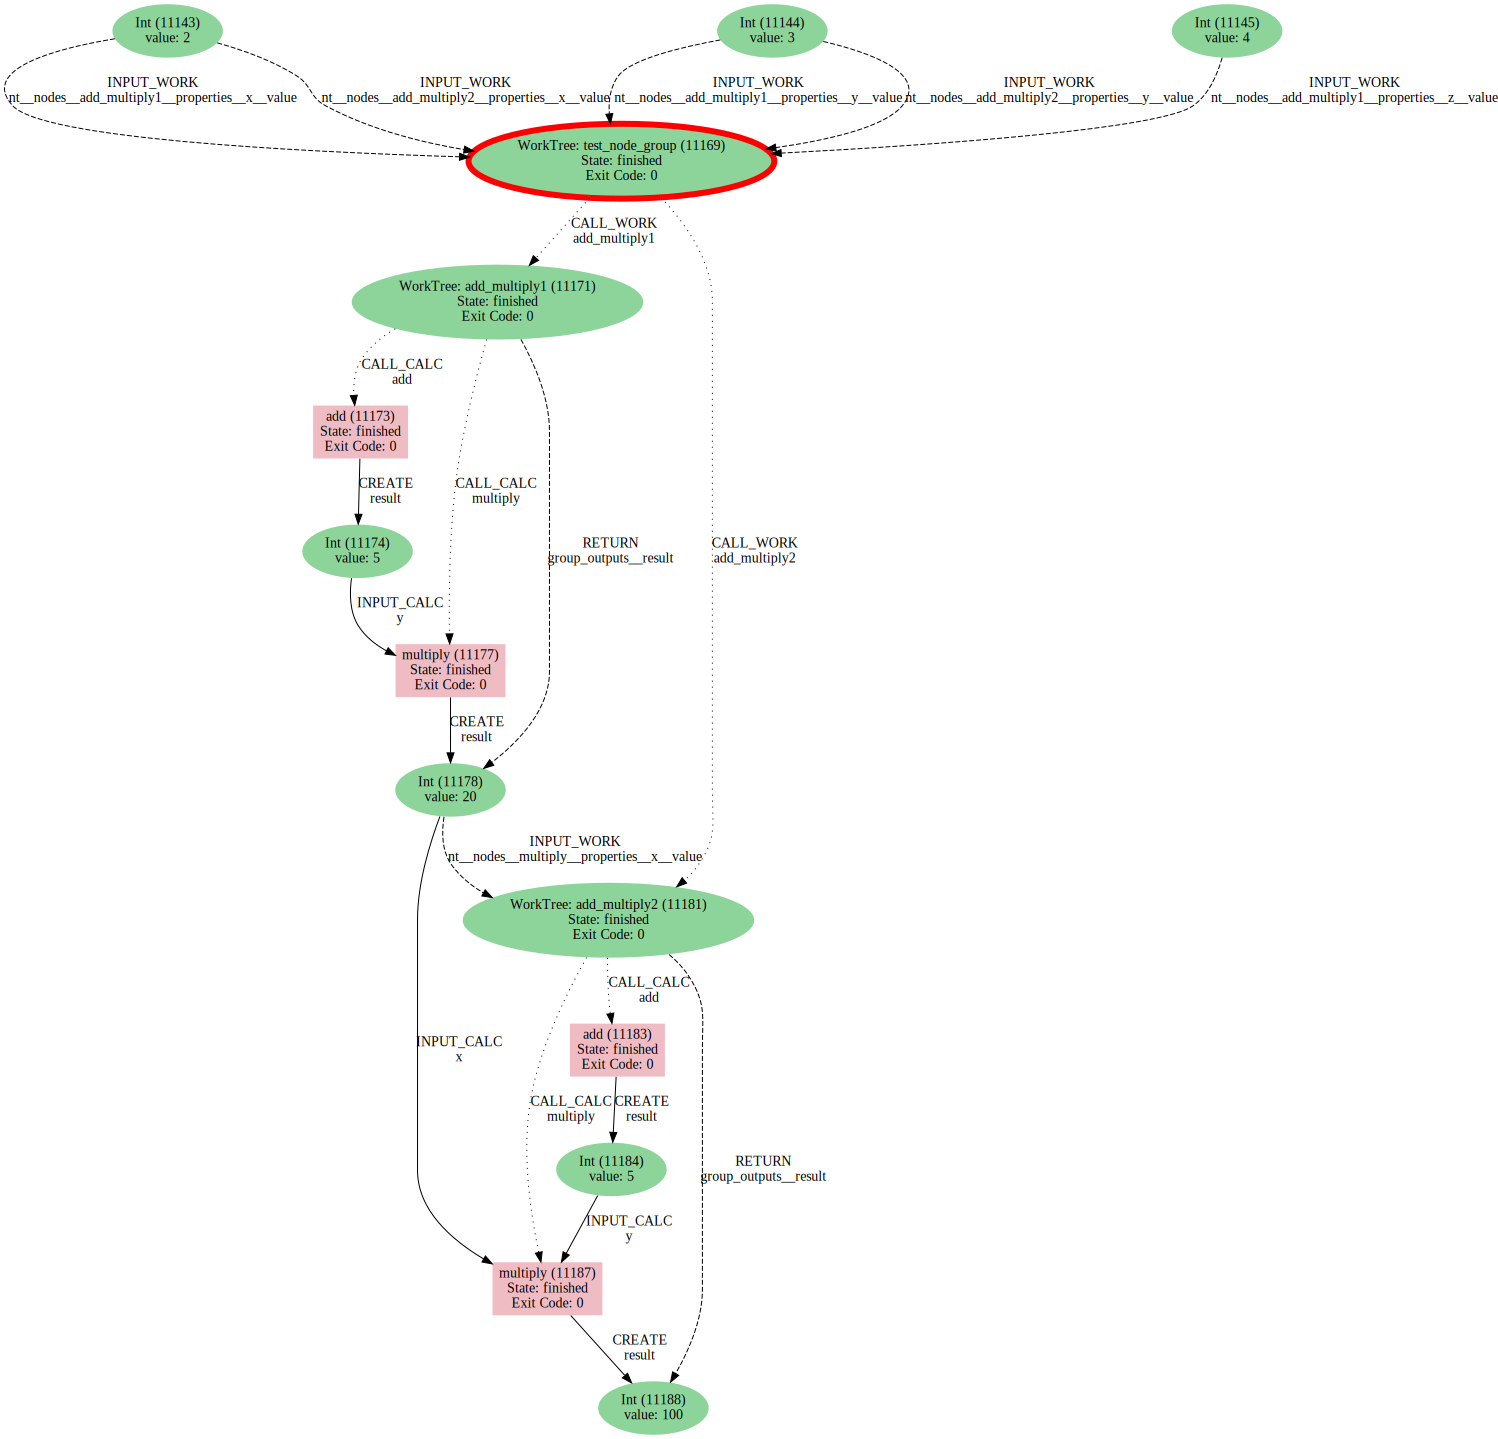

In [14]:
generate_node_graph(nt.pk)